# Economics Simulation

This is a simulation of an economic marketplace in which there is a *population* of actors, each of which has a level of wealth.  On each time step two actors (chosen by an *interaction function*) engage in a transaction that exchanges wealth between them (according to a *transaction function*).  The idea is to understand the evolution of the population's wealth over time.  I heard about the problem when I visited the Bard College Computer Science Department in 2008. *Update:* In 2017, a version posed by Uri Wilensky [became popular](http://www.decisionsciencenews.com/2017/06/19/counterintuitive-problem-everyone-room-keeps-giving-dollars-random-others-youll-never-guess-happens-next/). We cover his version [below](#Uri-Wilensky-Version).

![](money.png)

Why is this interesting? 
- It is an example of using simulation to model the world. The model is simple but captures some aspects of a complex world.
- Many students will have preconceptions about how economies work that will be challenged by the results shown here.
- It reveals subtle differences between computational thinking, mathematical thinking, and statistical thinking.

# Population Distributions

We will model a population as a list of `N` numbers, each number being one actor's wealth. We'll start with a Gaussian distribution (also known as a *normal* distribution or *bell-shaped curve*), with a mean wealth of 100 [simoleons](http://en.wiktionary.org/wiki/simoleon) and a standard deviation of 1/5 the mean:

In [1]:
import random

N  = 5000 # Default size of the population
MU = 100. # Default mean of the population

population = [random.gauss(mu=MU, sigma=MU/5) for _ in range(N)]

# Population Statistics and Visualization

How evenly is the wealth in a population distributed?  The traditional measure is the [Gini coefficient](http://en.wikipedia.org/wiki/Gini_coefficient), which Wikipedia says is computed by this formula (which assumes the *y* values are sorted):

![Gini](https://upload.wikimedia.org/math/b/b/5/bb50601acc135c45a24bb0493f7555b4.png)

A Gini index of 0 means total equality (everyone has the same amount), and values closer to 1 mean more inequality (most of the money in the hands of a few individuals).  Here's a table of Gini coefficients for several countries:

<table>
<tr><td>Sweden <td> 0.250
<tr><td>Canada <td> 0.326
<tr><td>Switzerland <td> 0.337
<tr><td>United States<td> 0.408
<tr><td>Chile <td> 0.521
<tr><td>South Africa <td> 0.631
</table>


The Gini coefficient is traditionally computed over *income*, but we will be dealing with *wealth*. Here is the computation:

In [2]:
def gini(y):
    "Compute the Gini coefficient (a measure of equality/inequality) in a population, y."
    y = sorted(y)
    n = len(y)
    numer = 2 * sum((i+1) * y[i] for i in range(n))
    denom = n * sum(y)
    return (numer / denom) - (n + 1) / n

In [3]:
gini(population)

0.11498216427020225

We'll define the function `hist` to plot a histogram of a population. Our `hist` wraps `plt.hist`, but with some specific keyword values:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def hist(population, label='pop', **kwargs):
    "A custom version of `hist` with better defaults."
    label = label + ': G=' + str(round(gini(population), 2))
    h = plt.hist(list(population), bins=30, alpha=0.5, label=label, **kwargs)
    plt.xlabel('wealth'); plt.ylabel('count'); plt.grid(True)
    plt.legend()

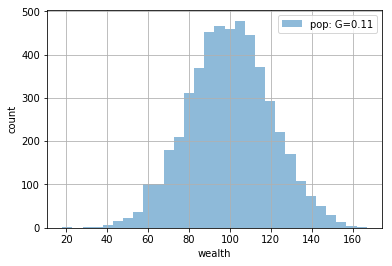

In [5]:
hist(population)

# Transactions

In a transaction, two actors come together and exchange some of their wealth. For now we will use a wealth-conserving transaction function in which all the wealth from both actors is put into a pot, which is then split randomly and uniformly between the two actors:

In [6]:
def random_split(A, B):
    "Take all the money in the pot and divide it randomly between the two actors."
    pot = A + B
    share = random.uniform(0, pot)
    return share, pot - share

In [7]:
random_split(100, 100)

(192.59786507689003, 7.402134923109969)

# Interactions

How do we decide which parties interact with each other?  We will define an interaction function that, given the size of the population, randomly selects any two actors in the populations (denoted by their index numbers in the list). We'll call this function `anyone`, meaning that any actor can interact with any other actor:

In [8]:
def anyone(N): return random.sample(range(N), 2)

In [9]:
anyone(N)

[1623, 3032]

# Simulation

The function `simulate` takes an initial population, calls an interaction function to select two actors, and a transaction function to split their wealth, and repeats this T times. After each transaction, we yield the population, so `simulate` yields the complete history of the simulation.

In [10]:
def step(population, transaction=random_split, interaction=anyone):
    "Modify the population by doing one transaction."
    i, j = interaction(len(population))
    population[i], population[j] = transaction(population[i], population[j]) 
    return population
    
def simulate(population, T, step=step, transaction=random_split, interaction=anyone):
    "Run simulation on population for T transactions; yield population at each time step."
    population = population.copy()
    yield population
    for t in range(T):
        yield step(population, transaction, interaction)

Here is a simple example of simulating a population of 4 actors for 8 time steps:

In [11]:
for pop in simulate([100] * 4, 8):
    print(pop)

[100, 100, 100, 100]
[74.32841260162783, 100, 125.67158739837217, 100]
[95.71835129942836, 78.61006130219947, 125.67158739837217, 100]
[174.3847061814956, 78.61006130219947, 47.005232516304915, 100]
[215.2484685788761, 78.61006130219947, 6.1414701189244285, 100]
[197.4331010042979, 96.4254288767777, 6.1414701189244285, 100]
[197.4331010042979, 96.4254288767777, 86.93648191446609, 19.20498820445835]
[197.4331010042979, 28.041981625882613, 86.93648191446609, 87.58843545535343]
[197.4331010042979, 10.360838235754827, 104.61762530459387, 87.58843545535343]


# Simulation Visualization

If we want to do larger simulations we'll need a better way to visualize the results.
The function `show` does that:

In [18]:
import statistics

def show(population, k=40, percentiles=(1, 10, 50, 90, 99), **kwargs):
    "Run a simulation for k*N steps, printing statistics and displaying a plot and histogram."
    N = len(population)
    start = list(population)
    results = [(t, sorted(pop)) # Sort results so that percentiles work
               for (t, pop) in enumerate(simulate(population, T=k * N, **kwargs))
               if t % (N / 10) == 0]
    # Printout:
    print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))
    print('------- ---- -----' + ' ----' * len(percentiles))
    fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
    for (t, pop) in results:
        if t % (k * N // 10) == 0: # Print 11 report lines (initial plus 10 as t varies)
            data = [percent(pct, pop) for pct in percentiles]
            print(fmt.format(t, gini(pop), statistics.stdev(pop), *data))

    plt.title('/'.join(map(str, percentiles)) + ' Percentile Plots')
    times = [t for (t, pop) in results]
    "plt.hold(True);"
    plt.xlabel('wealth'); 
    plt.ylabel('time'); 
    plt.grid(True)
    for pct in percentiles:
        line = [percent(pct, pop) for (t, pop) in results]
        plt.plot(line, times)
    plt.show()
    
    plt.title('Histograms')    
    R = (min(pop+start), max(pop+start))
    hist(start, 'start', range=R)
    hist(pop, 'end', range=R)
    plt.show()

    plt.title('Ordered Curves')
    order = list(range(len(pop)))
    start.sort()
    pop.sort()
    plt.plot(sorted(start), order, label='start')
    plt.plot(sorted(pop), order, label='end')
    plt.xlabel('wealth'); plt.ylabel('order'); plt.grid(True)
    plt.legend()

                
def percent(pct, items):
    "The item that is pct percent through the sorted list of items."
    return items[min(len(items)-1, len(items) * pct // 100)]

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  20.3   53   73  100  126  147
 20,000 0.49  94.9    1   10   74  229  444
 40,000 0.50  98.7    1   11   70  233  449
 60,000 0.50 100.4    1   10   69  230  448
 80,000 0.50  98.4    1   11   68  234  448
100,000 0.50  98.7    1   12   69  229  468
120,000 0.50  99.5    1   11   71  230  457
140,000 0.50  99.1    1   11   70  231  460
160,000 0.49  98.4    1   11   69  231  451
180,000 0.50  99.9    1   11   70  231  468
200,000 0.50  99.6    1   11   70  227  470


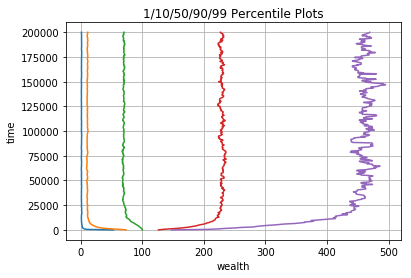

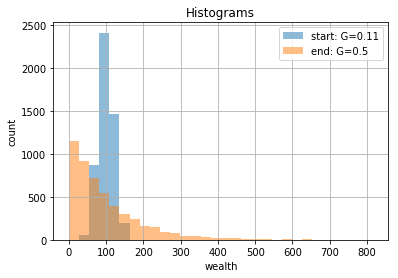

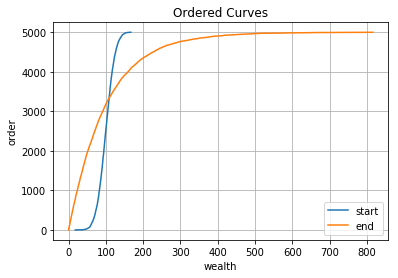

In [19]:
show(population)

There are four parts to this output:

**The printout:** For the starting population and for every 20,000 transactions along the way, we 
print the Gini coefficient and standard deviation of the population, and the wealths at five percentile points in the population: the 1%, 10%, 50% (median), 90% and 99% marks.

**The plots:** This shows the same information as the printout (except for the Gini index), but with more data points along the way. The leftmost (blue) line is the 1% mark, the rightmost (purple) is the 99% mark, and the inner lines are the 10%, 50% and 90% marks, respectively. For the plot, time goes from bottom to top rather than top to bottom. So, the 99% (purple) line starts at around 150, and over time increases to over 400, indicating that the richest 1% are getting richer. The fact that the lines are going more or less straight up after about 50,000 transactions suggests that the system has converged.

**The histograms:** The starting and ending populations are plotted as histograms. 

**The ordered curves:** Here the initial (blue) and final (green) populations are sorted, and the curves show wealth versus ordinal number. The poorest actor (ordinal number 0) has wealth 0 in both the initial and final populations. The 2000th poorest actor (a bit below the median; at the 40th percentile) has wealth of almost 100 in the initial population, but only about 50 in the final population.

The results show that income inequality is increasing over time. How can you tell? Because  the Gini coefficient is increasing over time, the standard deviation is increasing, and the 1% and 10% marks are decreasing (the blue and olive lines are moving left as time increases) while the 90% and 99% marks are increasing (the aqua and purple lines are moving right as time increases).



Would the population continue to change if we let the simulation run longer? It looks like only the 1% line is changing, the other lines remain pretty much in one place from about T=15,000 to T=25,000. This suggests that running the simulation longer would not have too much effect.

# Effect of Starting Population

What happens to the final result if we vary the starting population? I'll introduce the function `samples` to sample from a distribution function `n` times, normalizing the result to have the specified mean:

In [20]:
def samples(distribution, *args, n=N, mu=MU):
    "Sample from the distribution n times, then normalize results to have mean mu."
    numbers = [distribution(*args) for _ in range(N)]
    return normalize(numbers, mu)

def normalize(numbers, mu):
    "Make the numbers non-negative, and scale them so they have mean mu."
    numbers = [max(0, n) for n in numbers]
    factor = len(numbers) * mu / sum(numbers)
    return [x * factor for x in numbers]

Now we can easily make an initial population from a distribution function. I'll start with a uniform distribution:

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.33  57.8    2   20   99  180  198
 20,000 0.49  97.5    1   12   71  226  449
 40,000 0.50  99.8    1   11   70  230  455
 60,000 0.49  98.9    1   11   71  229  460
 80,000 0.50  99.2    1   11   70  232  453
100,000 0.49  98.6    1   11   70  228  458
120,000 0.50 100.4    1   10   70  231  465
140,000 0.50  98.8    1   11   70  232  459
160,000 0.50  98.0    1   11   70  233  436
180,000 0.49  99.2    1   11   70  227  470
200,000 0.50  98.4    1   11   69  233  461


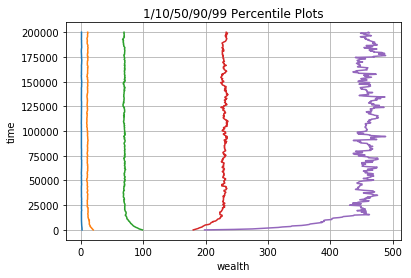

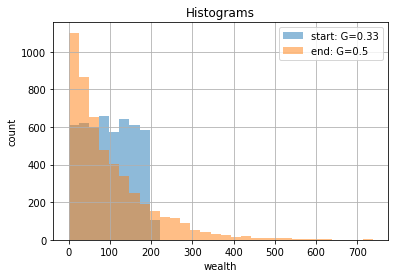

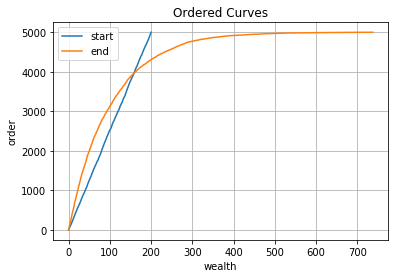

In [21]:
show(samples(random.uniform, 0, 200))

And try a constant distribution, where everyone starts out the same:

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.00   0.0  100  100  100  100  100
 20,000 0.48  94.3    1   11   72  227  423
 40,000 0.50 101.5    1   11   69  231  479
 60,000 0.50  99.6    1   11   71  229  458
 80,000 0.50  99.2    1   10   71  224  462
100,000 0.50  98.3    1   11   70  229  457
120,000 0.50 100.1    1   10   69  230  461
140,000 0.50  99.0    1    9   69  232  438
160,000 0.50  99.1    1   10   70  230  448
180,000 0.50 101.7    1   10   69  229  482
200,000 0.51 101.8    1   10   68  229  459


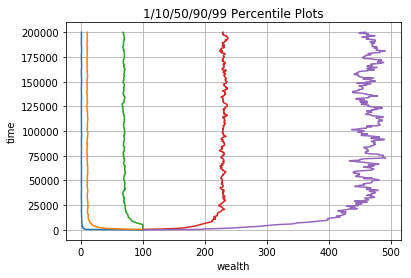

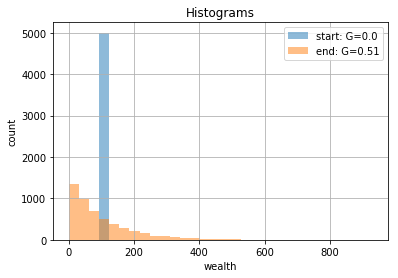

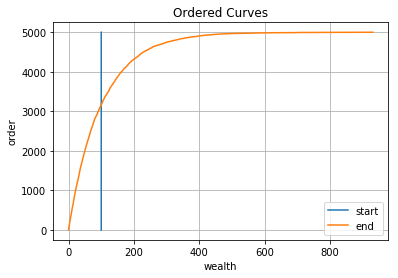

In [22]:
def constant(mu=MU): return mu

show(samples(constant))

The resulting histogram looks different, but only because the starting distribution is so narrow and tall; the end distribution has a Gini coefficient of about 1/2 and standard deviation of about 100, just like we get from the other starting distributions.

Here is one that statisticians call the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) (with carefully chosen parameters):

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.50  98.2    1   10   69  233  457
 20,000 0.50 100.6    1   11   69  234  466
 40,000 0.50  99.6    1   10   70  235  461
 60,000 0.50 101.4    1   10   69  229  475
 80,000 0.50  99.7    1   11   69  232  449
100,000 0.51 102.9    1   10   69  233  479
120,000 0.50  99.7    1   10   70  229  454
140,000 0.50 101.2    1   10   67  232  476
160,000 0.51 102.1    1   10   69  230  481
180,000 0.50 100.4    1   10   70  229  468
200,000 0.50 100.6    1   11   69  233  478


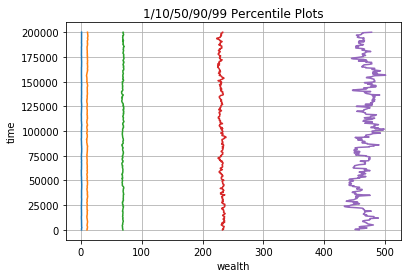

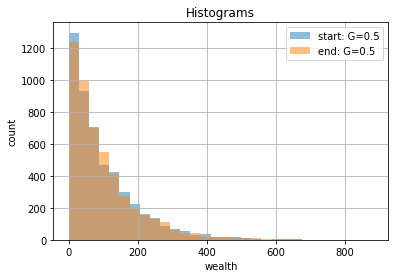

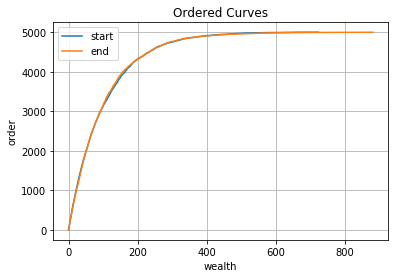

In [23]:
def beta(): return random.betavariate(0.9, 12)
    
show(samples(beta))

**Surprise:** We can confirm that the starting population doesn't matter much. I thought it would make a real difference, but we showed that three very different starting populations&mdash;Gaussian, uniform, and beta&mdash;all ended up with very similar final populations; all with G around 1/2 and standard deviation around 100. The final distribution in all three cases looks similar to the normalized beta(0.9, 12) distribution.

# Effect of Transaction Function

Does the transaction function have an effect on the outcome? So far we've only used the `random_split` transaction function; we'll now compare that to the `winner_take_all` function, in which the wealth from both actors is thrown into a pot, and one of them takes all of it:

In [24]:
def winner_take_all(A, B): return random.choice(([A + B, 0], [0, A + B]))

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  20.3   53   73  100  126  147
 20,000 0.89 300.8    0    0    0  348 1412
 40,000 0.94 414.0    0    0    0  104 2072
 60,000 0.96 515.0    0    0    0    0 2632
 80,000 0.97 579.5    0    0    0    0 2957
100,000 0.98 644.7    0    0    0    0 3287
120,000 0.98 687.3    0    0    0    0 3432
140,000 0.98 750.7    0    0    0    0 3499
160,000 0.99 814.5    0    0    0    0 3462
180,000 0.99 858.0    0    0    0    0 3660
200,000 0.99 889.7    0    0    0    0 3683


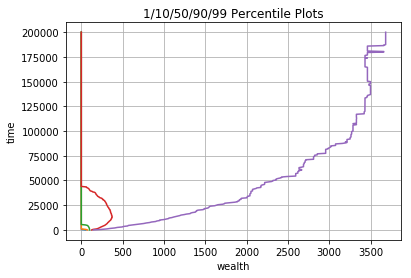

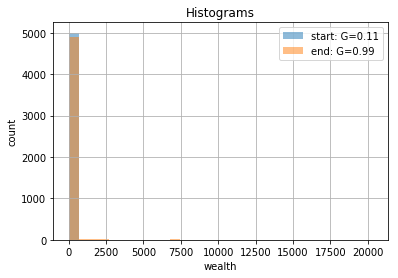

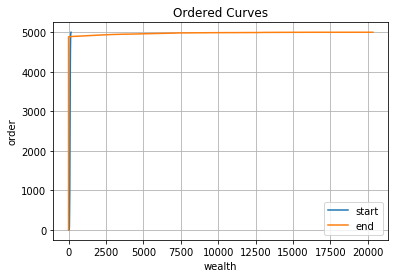

In [25]:
show(population, transaction=winner_take_all)

Now the results look **very** different: most of the wealth goes to the 99th percentile (purple line on the far right of  the plot), with everybody else getting wiped out (although the 90th percentile holds out until around 50,000 transactions). The Gini coefficient is all the way up to 0.99 and the standard deviation is over 800, and still rising.

That makes sense: any time two actors with non-zero wealth interact, one of them will end up with zero&mdash;the number of actors with zero wealth increases monotonically until all the wealth is with one actor, and from then on the wealth just gets swapped around.

At the other end of the spectrum, let's try a transaction function, `redistribute`, that taxes both parties 31% (the average income tax rate in the US) and splits that tax revenue evenly among the two parties; the non-taxed part is split with `random_split`:

In [26]:
def redistribute(A, B, rate=0.31):
    "Tax both parties at rate; split the tax revenue evenly, and randomly split the rest."
    tax = rate * (A + B)
    Arand, Brand = random_split(A + B - tax, 0)
    return tax / 2 + Arand, tax / 2 + Brand

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  20.3   53   73  100  126  147
 20,000 0.33  60.6   17   35   87  182  282
 40,000 0.33  60.6   17   35   86  186  283
 60,000 0.33  60.6   17   35   87  183  296
 80,000 0.33  61.4   17   35   87  182  305
100,000 0.33  60.8   17   35   87  182  291
120,000 0.33  61.5   17   35   86  183  293
140,000 0.33  60.1   17   35   88  183  287
160,000 0.33  61.1   17   35   86  184  289
180,000 0.33  61.1   17   35   86  184  291
200,000 0.33  61.4   16   35   85  182  301


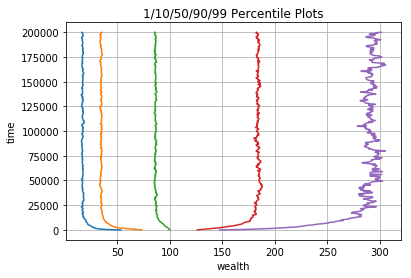

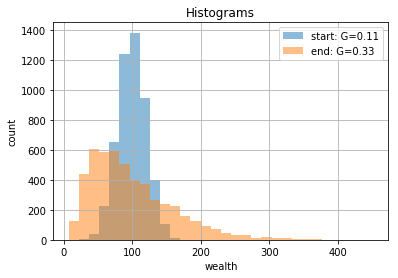

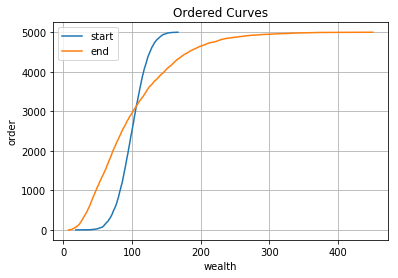

In [27]:
show(population, transaction=redistribute)

**Another surprise:** This transaction function does indeed lead to less inequality than `split_randomly` or `winner_take_all`, but surprisingly (to me) it still increases inequality compared to the initial (Gaussian) population.

Here's one more interaction function, `status_quo`, in which both actors keep half of their wealth out of the transaction, and the other half is randomly split using a triangular distribution in such a way that the most likely outcome is that each actor keeps what they started with, but from there probability falls off on either side, making larger and larger deviations from the status quo less and less likely:

In [28]:
def status_quo(A, B):
    "A transaction that is most likely to leave things unchanged, but could move any amount of wealth around."
    a = random.triangular(0, (A + B) / 2, A / 2)
    return (A / 2 + a), (A + B) - (A / 2 + a)

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  20.3   53   73  100  126  147
 20,000 0.22  38.9   32   55   94  153  211
 40,000 0.23  40.9   30   52   95  155  221
 60,000 0.23  41.0   31   52   94  154  223
 80,000 0.23  41.5   31   53   93  156  225
100,000 0.22  40.6   30   53   94  154  223
120,000 0.22  40.6   32   53   94  156  217
140,000 0.23  41.6   30   53   94  155  222
160,000 0.23  41.0   30   52   94  154  214
180,000 0.23  41.6   31   52   94  155  226
200,000 0.23  40.8   28   52   94  155  217


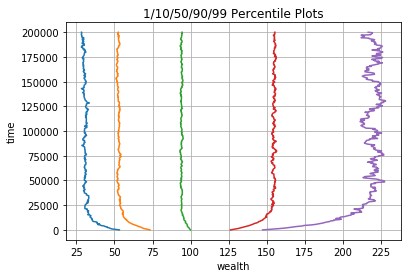

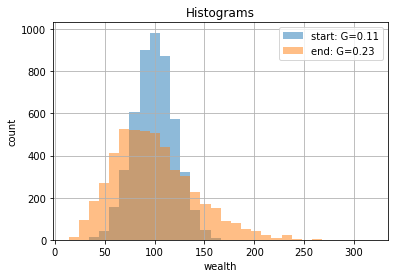

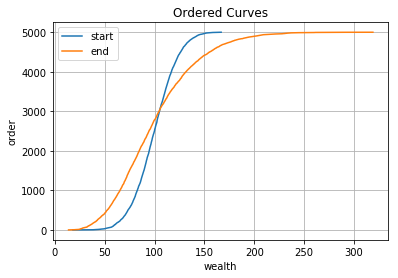

In [29]:
show(population, transaction=status_quo)

The `status_quo` transaction increases inequality from the initial population, but not as much as the other transaction functions.

# Effect of Interaction Function

We have been using `anyone` as our interaction function: anyone can enter into a transaction with anyone else. Suppose that transactions are constrained to be *local*&mdash;that you can only do business with your close neighbors.  Will that make income more equitable, because there will be no large, global conglomorates?  

In [30]:
def neighborhood(n, width=5): 
    "Choose two agents in the same neighborhood"
    i = random.randrange(n - width)
    return random.sample(range(i, i + width + 1), 2)

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  20.3   53   73  100  126  147
 20,000 0.48  93.6    1   11   73  224  425
 40,000 0.49  96.2    1   11   72  226  445
 60,000 0.48  93.6    1   11   71  227  418
 80,000 0.49  97.2    1   11   70  229  451
100,000 0.50  98.3    1   11   71  228  464
120,000 0.49  95.6    1   11   72  227  444
140,000 0.49  97.2    1   11   71  229  444
160,000 0.50  98.7    1   11   69  232  453
180,000 0.50  99.2    1   10   69  230  465
200,000 0.49  98.0    1   11   71  233  435


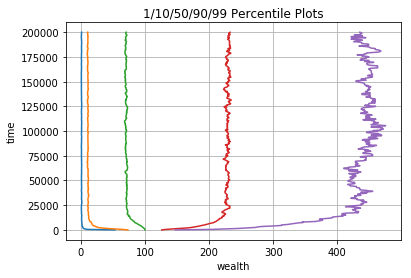

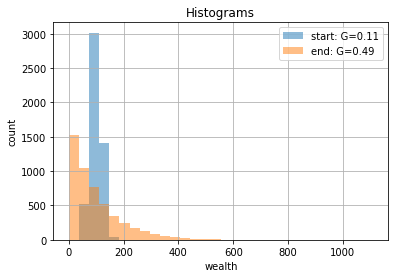

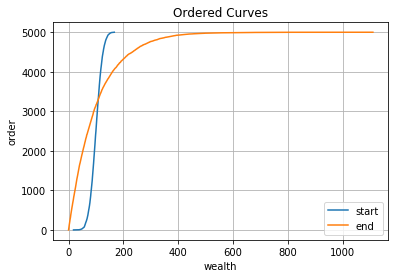

In [31]:
show(population, interaction=neighborhood)

**Surprise:** The `neighborhood` interaction is not too different from the `anyone` interaction.  

Let's get even more local, allowing trade only with your immediate neighbor (to either side):

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  20.3   53   73  100  126  147
 20,000 0.45  83.8    1   13   79  220  361
 40,000 0.47  90.0    1   12   75  222  404
 60,000 0.48  91.8    1   11   74  227  409
 80,000 0.48  92.2    1   11   74  228  400
100,000 0.48  90.8    1   12   74  227  399
120,000 0.48  93.1    1   12   72  225  414
140,000 0.49  96.0    1   11   71  234  439
160,000 0.49  94.4    1   12   71  230  423
180,000 0.48  95.1    1   11   72  223  447
200,000 0.50  99.0    1   10   70  233  453


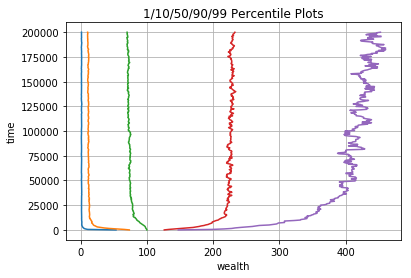

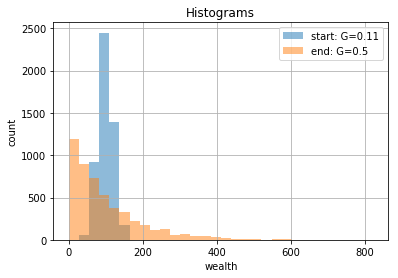

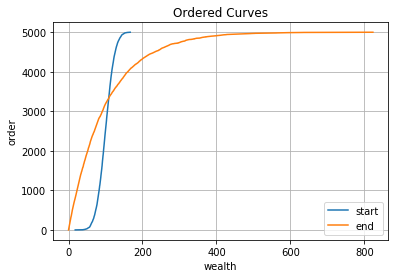

In [32]:
def adjacent(n): return neighborhood(n, 1)
    
show(population, interaction=adjacent)

It is still surprising that we still have no efect from restricting trade.

# United States Distribution

We've drawn from mathematical distributions; let's look at the actual distribution of family income in the United States. Each row in the following table is a tuple giving the lower bound and upper bound (in thousands of dollars of income), followed by the cumulative percentage of families in the row or a previous row. The table I got this from actually had "\$250,000 or above" as the final row; I had to cut it off somewhere, and arbitrarily chose \$300,000.

In [33]:
USA_table = [  
  (0,    10,  7.63),
  (10,   20, 19.20),
  (20,   30, 30.50),
  (30,   40, 41.08),
  (40,   50, 49.95),
  (50,   60, 57.73),
  (60,   70, 64.56),
  (70,   80, 70.39),
  (80,   90, 75.02),
  (90,  100, 79.02),
  (100, 110, 82.57),
  (110, 120, 85.29),
  (120, 130, 87.60),
  (130, 140, 89.36),
  (140, 150, 90.95),
  (150, 160, 92.52),
  (160, 170, 93.60),
  (170, 180, 94.55),
  (180, 190, 95.23),
  (190, 200, 95.80),
  (200, 250, 97.70),
  (250, 300, 100.0)]

def USA():
    "Sample from the USA distribution."
    p = random.uniform(0, 100)
    for (lo, hi, cum_pct) in USA_table:
        if p <= cum_pct:
            return random.uniform(lo, hi) 

Let's see what it looks like:

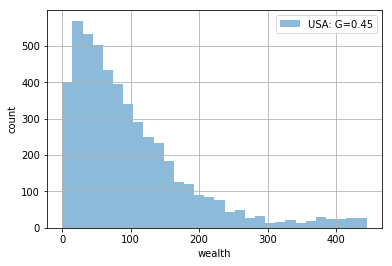

In [34]:
hist(samples(USA), label='USA')

Hey&mdash;that looks like the beta distribution. Let's compare:

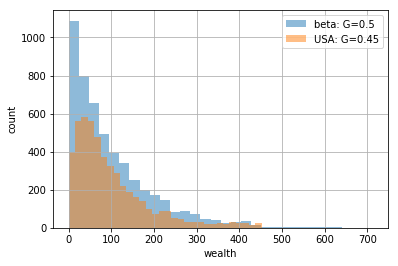

In [35]:
hist(samples(beta), label='beta')
hist(samples(USA), label='USA')

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.45  88.9    2   18   74  221  424
 20,000 0.50 100.3    1   10   68  231  454
 40,000 0.51 103.0    1   10   68  230  494
 60,000 0.50  98.6    1   10   71  230  449
 80,000 0.50 100.8    1   10   68  234  478
100,000 0.50 101.3    1   10   69  231  446
120,000 0.50 101.0    1   11   70  230  478
140,000 0.50 101.3    1   11   69  232  478
160,000 0.50  99.6    1   11   70  227  464
180,000 0.49  99.8    1   12   70  225  449
200,000 0.50 101.1    1   11   68  227  458


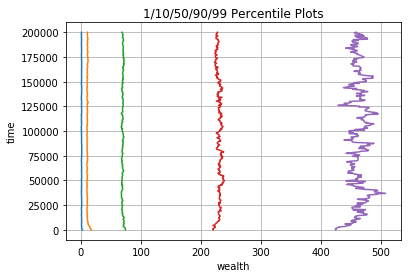

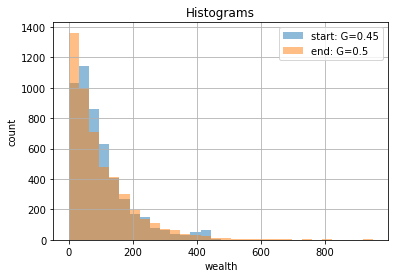

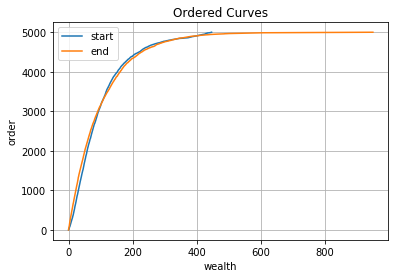

In [36]:
show(samples(USA))

The USA distribution is indeed similar to the beta(0.9, 12) distribution, and to the stationary ending distribution.

# Uri Wilensky Version

[Another version](http://www.decisionsciencenews.com/2017/06/19/counterintuitive-problem-everyone-room-keeps-giving-dollars-random-others-youll-never-guess-happens-next/) of this simulation made the rounds in 2017. This version has these rules:

>Imagine a room full of 100 people with 100 dollars each. With every tick of the clock, every person with money gives a dollar to one randomly chosen other person. After some time progresses, how will the money be distributed?

To implement this all-at-once transactions rather than one-at-a-time transactions, I'll define a new `step` function:

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.00   0.0  100  100  100  100  100
  2,000 0.26  45.8    3   42  106  158  221
  4,000 0.32  58.3    1   34   92  175  296
  6,000 0.37  66.7    1   21   89  191  342
  8,000 0.41  74.5    2   15   91  210  306
 10,000 0.45  81.2    7   14   86  229  336
 12,000 0.46  83.9    1   11   67  239  332
 14,000 0.48  87.6    0    8   79  225  366
 16,000 0.47  87.2    3   11   74  226  387
 18,000 0.48  89.0    0    9   76  221  387
 20,000 0.47  86.2    3   13   71  218  411


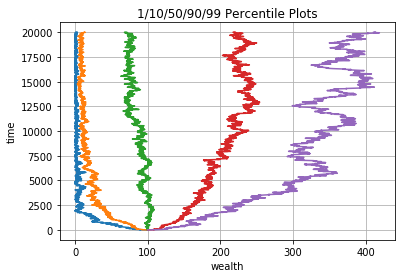

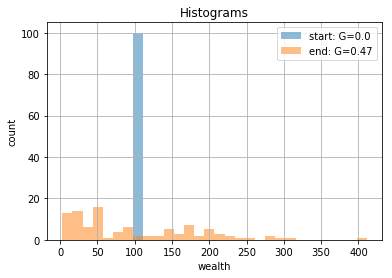

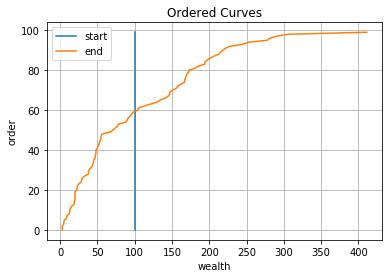

In [37]:
def give_dollar(population, transaction, interaction):
    "Everyone with at least a dollar gives a dollar to a random person."
    N = len(population)
    for i in range(N):
        if population[i] >= 1:
            population[i] -= 1
            population[random.randrange(N)] += 1
    return population

show([100] * 100, k=200, step=give_dollar)

So we see that inequality rises from a Gini of 0 to about 1/2 over 20,000 time steps. Let's try again starting from the first 100 actors from our initial (Gaussian) population:

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  21.0   59   77   99  134  159
  2,000 0.24  43.7   14   43  103  160  215
  4,000 0.29  53.2    4   35   99  175  255
  6,000 0.35  64.8    7   21  103  178  377
  8,000 0.37  69.0    2   23   96  187  373
 10,000 0.40  74.0    2   16   93  188  342
 12,000 0.40  74.9    3   18   93  203  351
 14,000 0.43  80.5    2   10   83  219  350
 16,000 0.42  78.6    1   13   89  228  330
 18,000 0.46  86.3    2   19   76  253  328
 20,000 0.48  90.8    0   11   72  255  341


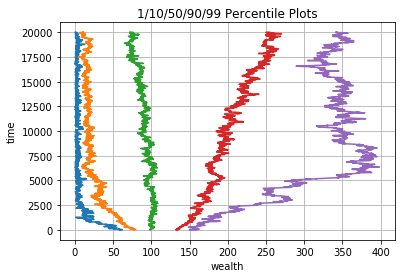

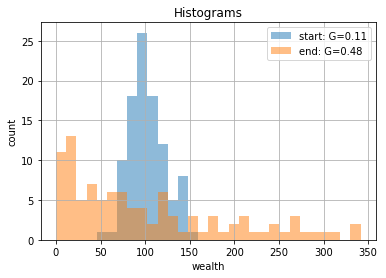

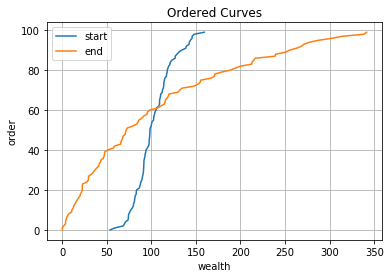

In [38]:
show(population[:100], k=200, step=give_dollar)

# A Mathematician, a Statistician, and a Programmer walk into a problem ...

In 2013, mathematician George Andrew's editorial *[Drowning in the Data Deluge](http://www.ams.org/notices/201207/rtx120700933p.pdf)* complains of an "overblown enthusiasm for data analysis." The tone was that this new fad for "big data" was taking away from traditional mathematics.

Two Stanford professors, mathematician Persi Diaconis and 
statistician Susan Holmes, were more accepting of new ideas. The three of us got to discussing Andrew's editorial and the differences between mathematical, statistical, and computational thinking. At the time, I had just heard about the economics problem covered in this notebook, and I suggested the three of us work on it, and compare approaches and results.
In the end, all three of us found similar results, in that we all identified the shape of the final distribution. But there were differences in how we got there:

**Mathematical thinking** (Persi):

- **Tool:** Paper and pencil.
- **Notes:** The process can be modeled by a Markov chain, using the same techniques as in [this paper](http://statweb.stanford.edu/~cgates/PERSI/papers/kac10.pdf). In the limit, there is a difference between the continuous case (where money is a real number, and the distribution is stationary), and the discrete case (where money comes in integer amounts and the distribution is not ergodic as there is an absorbing state). 

**Statistical thinking** (Susan):

- **Tool:** Simulation in `R`, with N=10 actors for T=1,000 transactions.
- **Notes**: this is extremely similar to what happens for random genetic drift in generations, that also gives clumping (and extinction of some of the alleles).

**Computational thinking** (Peter):

- **Tool:** Simulation in `IPython`, with N=5000 actors for T=200,000 transactions.
- **Notes**: Results are very similar to Susan's, but with more variations explored and more pretty pictures.